<a href="https://colab.research.google.com/github/srivatsan88/Mastering-Apache-Spark/blob/master/pyspark_ML_Pipeline_and_h2o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
!ls /usr/lib/jvm/

default-java		   java-11-openjdk-amd64     java-8-openjdk-amd64
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64


In [3]:
!pip install h2o-pysparkling-2.4

     |████████████████████████████████| 168.2MB 80kB/s 
  Created wheel for h2o-pysparkling-2.4: filename=h2o_pysparkling_2.4-3.32.0.4.post1-py2.py3-none-any.whl size=168391009 sha256=5cc9f587d2b62f960d15c9b7a6c35f92a1a08aec8a58427c1e5e798f7aab88aa
  Stored in directory: /root/.cache/pip/wheels/2b/ed/97/25ca99a843347561ea277037fab604b2fd977222b1fc21b333
Successfully built h2o-pysparkling-2.4


In [4]:
!pip install -U pyarrow

Requirement already up-to-date: pyarrow in /usr/local/lib/python3.7/dist-packages (3.0.0)


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.executor.memory", "4g")
spark.conf.set("spark.driver.memory", "4g")
spark.conf.set("spark.memory.fraction","0.9")

In [7]:
import sys,tempfile, urllib.request

In [8]:
BASE_DIR = '/tmp'
OUTPUT_FILE = os.path.join(BASE_DIR, 'credit_data.csv')

In [9]:
credit_data=urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', OUTPUT_FILE)

In [10]:
!ls

sample_data  spark-2.4.7-bin-hadoop2.7	spark-2.4.7-bin-hadoop2.7.tgz


In [11]:
credit_df = spark.read.option("inferSchema", "true").csv("/tmp/credit_data.csv", header=False).toDF("c1","c2","c3","c4","c5", "c6", "c7", "c8", "c9", "c10", "c11", "c12", "c13", "c14", "c15","c16")

In [12]:
credit_df.show()

+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+---+
| c1|   c2|    c3| c4| c5| c6| c7|   c8| c9|c10|c11|c12|c13|  c14|  c15|c16|
+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+---+
|  b|30.83|   0.0|  u|  g|  w|  v| 1.25|  t|  t|  1|  f|  g|00202|    0|  +|
|  a|58.67|  4.46|  u|  g|  q|  h| 3.04|  t|  t|  6|  f|  g|00043|  560|  +|
|  a|24.50|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280|  824|  +|
|  b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t|  5|  t|  g|00100|    3|  +|
|  b|20.17| 5.625|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|00120|    0|  +|
|  b|32.08|   4.0|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|00360|    0|  +|
|  b|33.17|  1.04|  u|  g|  r|  h|  6.5|  t|  f|  0|  t|  g|00164|31285|  +|
|  a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g|00080| 1349|  +|
|  b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|00180|  314|  +|
|  b|42.50| 4.915|  y|  p|  w|  v|3.165|  t|  f|  0|  t|  g|00052| 1442|  +|

In [13]:
credit_df.groupBy("c16").count().show()

+---+-----+
|c16|count|
+---+-----+
|  +|  307|
|  -|  383|
+---+-----+



In [14]:
from pyspark.sql.functions import isnan, when, count, col
credit_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in credit_df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| c1| c2| c3| c4| c5| c6| c7| c8| c9|c10|c11|c12|c13|c14|c15|c16|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



In [15]:
credit_df=credit_df.withColumn("c16", when(col("c16") == "+", 1).otherwise(0))


In [16]:
credit_df.show()

+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+---+
| c1|   c2|    c3| c4| c5| c6| c7|   c8| c9|c10|c11|c12|c13|  c14|  c15|c16|
+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+---+
|  b|30.83|   0.0|  u|  g|  w|  v| 1.25|  t|  t|  1|  f|  g|00202|    0|  1|
|  a|58.67|  4.46|  u|  g|  q|  h| 3.04|  t|  t|  6|  f|  g|00043|  560|  1|
|  a|24.50|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280|  824|  1|
|  b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t|  5|  t|  g|00100|    3|  1|
|  b|20.17| 5.625|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|00120|    0|  1|
|  b|32.08|   4.0|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|00360|    0|  1|
|  b|33.17|  1.04|  u|  g|  r|  h|  6.5|  t|  f|  0|  t|  g|00164|31285|  1|
|  a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g|00080| 1349|  1|
|  b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|00180|  314|  1|
|  b|42.50| 4.915|  y|  p|  w|  v|3.165|  t|  f|  0|  t|  g|00052| 1442|  1|

In [17]:
credit_df.printSchema()

root
 |-- c1: string (nullable = true)
 |-- c2: string (nullable = true)
 |-- c3: double (nullable = true)
 |-- c4: string (nullable = true)
 |-- c5: string (nullable = true)
 |-- c6: string (nullable = true)
 |-- c7: string (nullable = true)
 |-- c8: double (nullable = true)
 |-- c9: string (nullable = true)
 |-- c10: string (nullable = true)
 |-- c11: integer (nullable = true)
 |-- c12: string (nullable = true)
 |-- c13: string (nullable = true)
 |-- c14: string (nullable = true)
 |-- c15: integer (nullable = true)
 |-- c16: integer (nullable = false)



In [18]:
credit_df.describe().show()

+-------+----+-----------------+------------------+----+----+----+----+------------------+----+----+-----------------+----+----+------------------+------------------+------------------+
|summary|  c1|               c2|                c3|  c4|  c5|  c6|  c7|                c8|  c9| c10|              c11| c12| c13|               c14|               c15|               c16|
+-------+----+-----------------+------------------+----+----+----+----+------------------+----+----+-----------------+----+----+------------------+------------------+------------------+
|  count| 690|              690|               690| 690| 690| 690| 690|               690| 690| 690|              690| 690| 690|               690|               690|               690|
|   mean|null|31.56817109144546|4.7587246376811585|null|null|null|null|2.2234057971014476|null|null|              2.4|null|null|184.01477104874445|1017.3855072463768|0.4449275362318841|
| stddev|null|11.95786249827088| 4.978163248528541|null|null|null|null

In [19]:
from pyspark.sql.types import *

credit_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in credit_df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| c1| c2| c3| c4| c5| c6| c7| c8| c9|c10|c11|c12|c13|c14|c15|c16|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



In [20]:
credit_df.select([count(when(col(c)=='?', c)).alias(c) for c in credit_df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| c1| c2| c3| c4| c5| c6| c7| c8| c9|c10|c11|c12|c13|c14|c15|c16|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 12| 12|  0|  6|  6|  9|  9|  0|  0|  0|  0|  0|  0| 13|  0|  0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



In [21]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

crp_df=credit_df.toPandas()

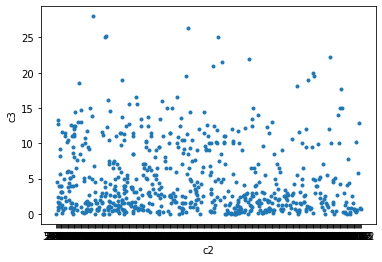

In [22]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(crp_df['c2'], crp_df['c3'], '.')
plt.xlabel('c2')
plt.ylabel('c3')
display()

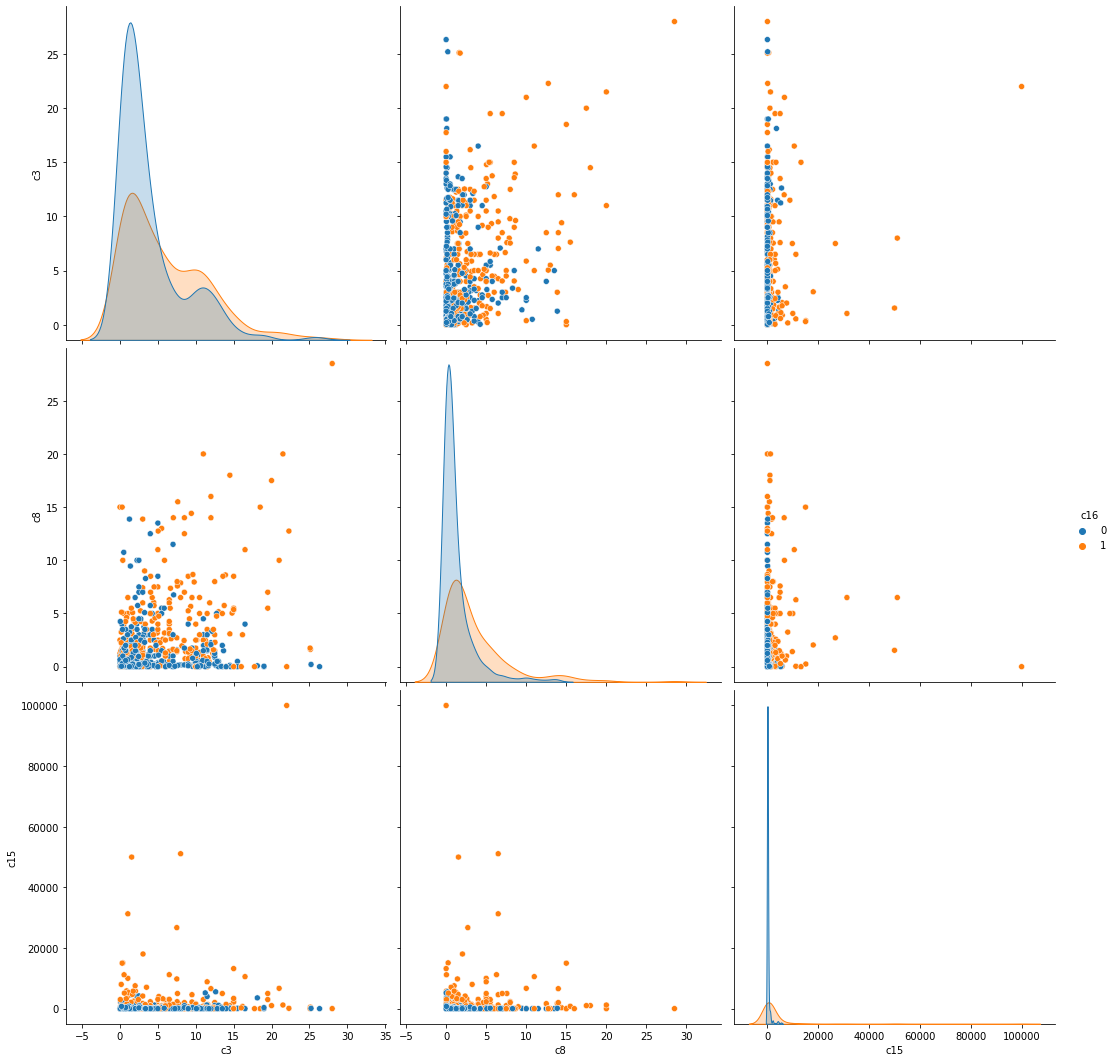

In [23]:
import seaborn as sns

g = sns.pairplot(crp_df[['c2','c3', 'c8','c14','c15','c16']], hue ='c16', height=5)

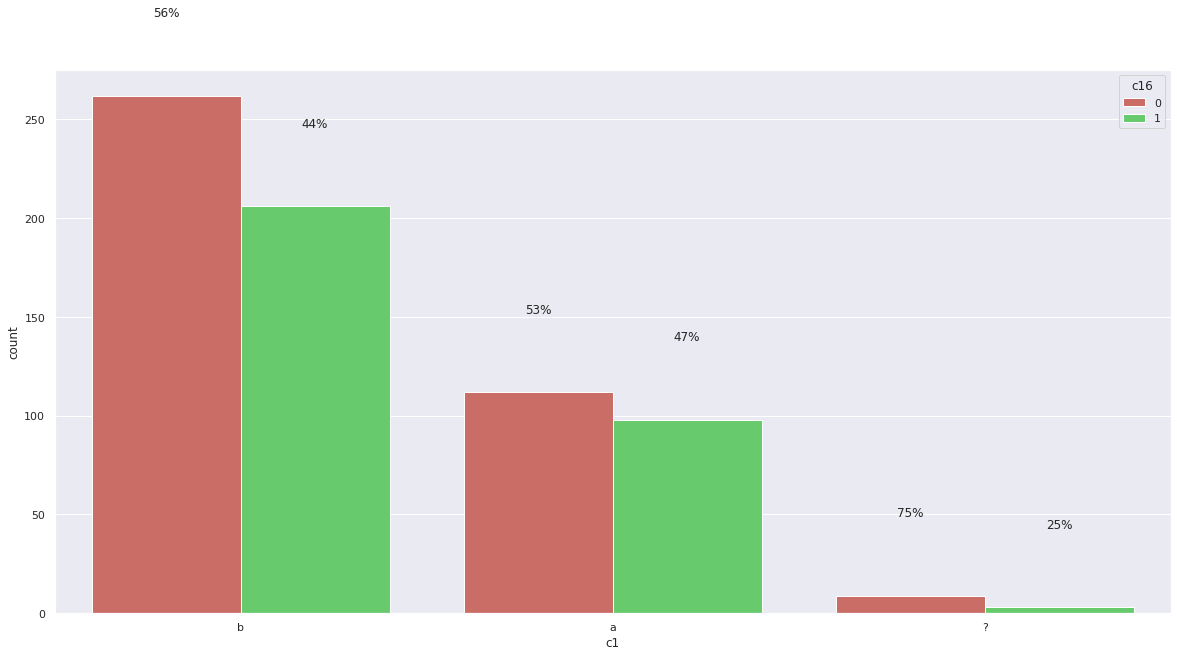

In [24]:
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="c1", hue="c16", data=crp_df)

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

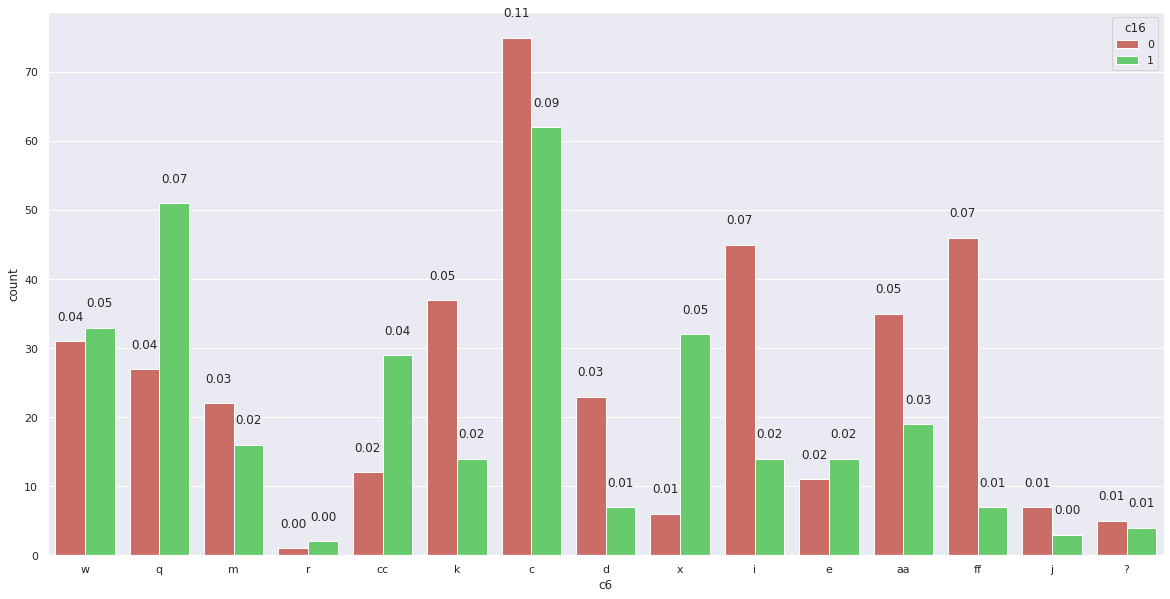

In [25]:
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="c6", hue="c16", data=crp_df)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/crp_df.shape[0]),
            ha="center") 

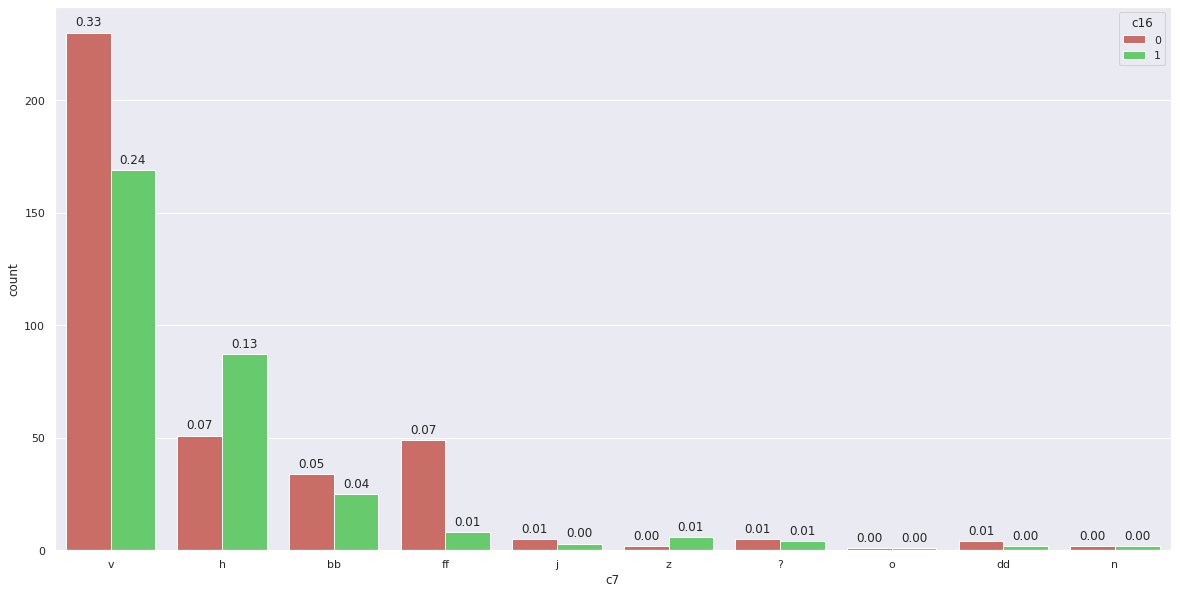

In [26]:
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="c7", hue="c16", data=crp_df)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/crp_df.shape[0]),
            ha="center") 

In [27]:
from pyspark.sql.functions import *

credit_df=credit_df.replace('?', None)

In [28]:
from pyspark.sql.functions import isnan, when, count, col
credit_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in credit_df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| c1| c2| c3| c4| c5| c6| c7| c8| c9|c10|c11|c12|c13|c14|c15|c16|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 12| 12|  0|  6|  6|  9|  9|  0|  0|  0|  0|  0|  0| 13|  0|  0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



In [29]:
credit_df=credit_df.withColumn("c14", col("c14").cast("int")).withColumn("c2", col("c2").cast("double"))

In [30]:
credit_df.printSchema()

root
 |-- c1: string (nullable = true)
 |-- c2: double (nullable = true)
 |-- c3: double (nullable = true)
 |-- c4: string (nullable = true)
 |-- c5: string (nullable = true)
 |-- c6: string (nullable = true)
 |-- c7: string (nullable = true)
 |-- c8: double (nullable = true)
 |-- c9: string (nullable = true)
 |-- c10: string (nullable = true)
 |-- c11: integer (nullable = true)
 |-- c12: string (nullable = true)
 |-- c13: string (nullable = true)
 |-- c14: integer (nullable = true)
 |-- c15: integer (nullable = true)
 |-- c16: integer (nullable = false)



In [31]:
credit_df.show()

+---+-----+------+---+---+---+---+-----+---+---+---+---+---+---+-----+---+
| c1|   c2|    c3| c4| c5| c6| c7|   c8| c9|c10|c11|c12|c13|c14|  c15|c16|
+---+-----+------+---+---+---+---+-----+---+---+---+---+---+---+-----+---+
|  b|30.83|   0.0|  u|  g|  w|  v| 1.25|  t|  t|  1|  f|  g|202|    0|  1|
|  a|58.67|  4.46|  u|  g|  q|  h| 3.04|  t|  t|  6|  f|  g| 43|  560|  1|
|  a| 24.5|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|280|  824|  1|
|  b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t|  5|  t|  g|100|    3|  1|
|  b|20.17| 5.625|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|120|    0|  1|
|  b|32.08|   4.0|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|360|    0|  1|
|  b|33.17|  1.04|  u|  g|  r|  h|  6.5|  t|  f|  0|  t|  g|164|31285|  1|
|  a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g| 80| 1349|  1|
|  b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|180|  314|  1|
|  b| 42.5| 4.915|  y|  p|  w|  v|3.165|  t|  f|  0|  t|  g| 52| 1442|  1|
|  b|22.08|  0.83|  u|  g

In [32]:
categorical=['c1','c4','c5','c6','c7','c9','c10','c12','c13']

In [33]:
crp_df=credit_df.toPandas()

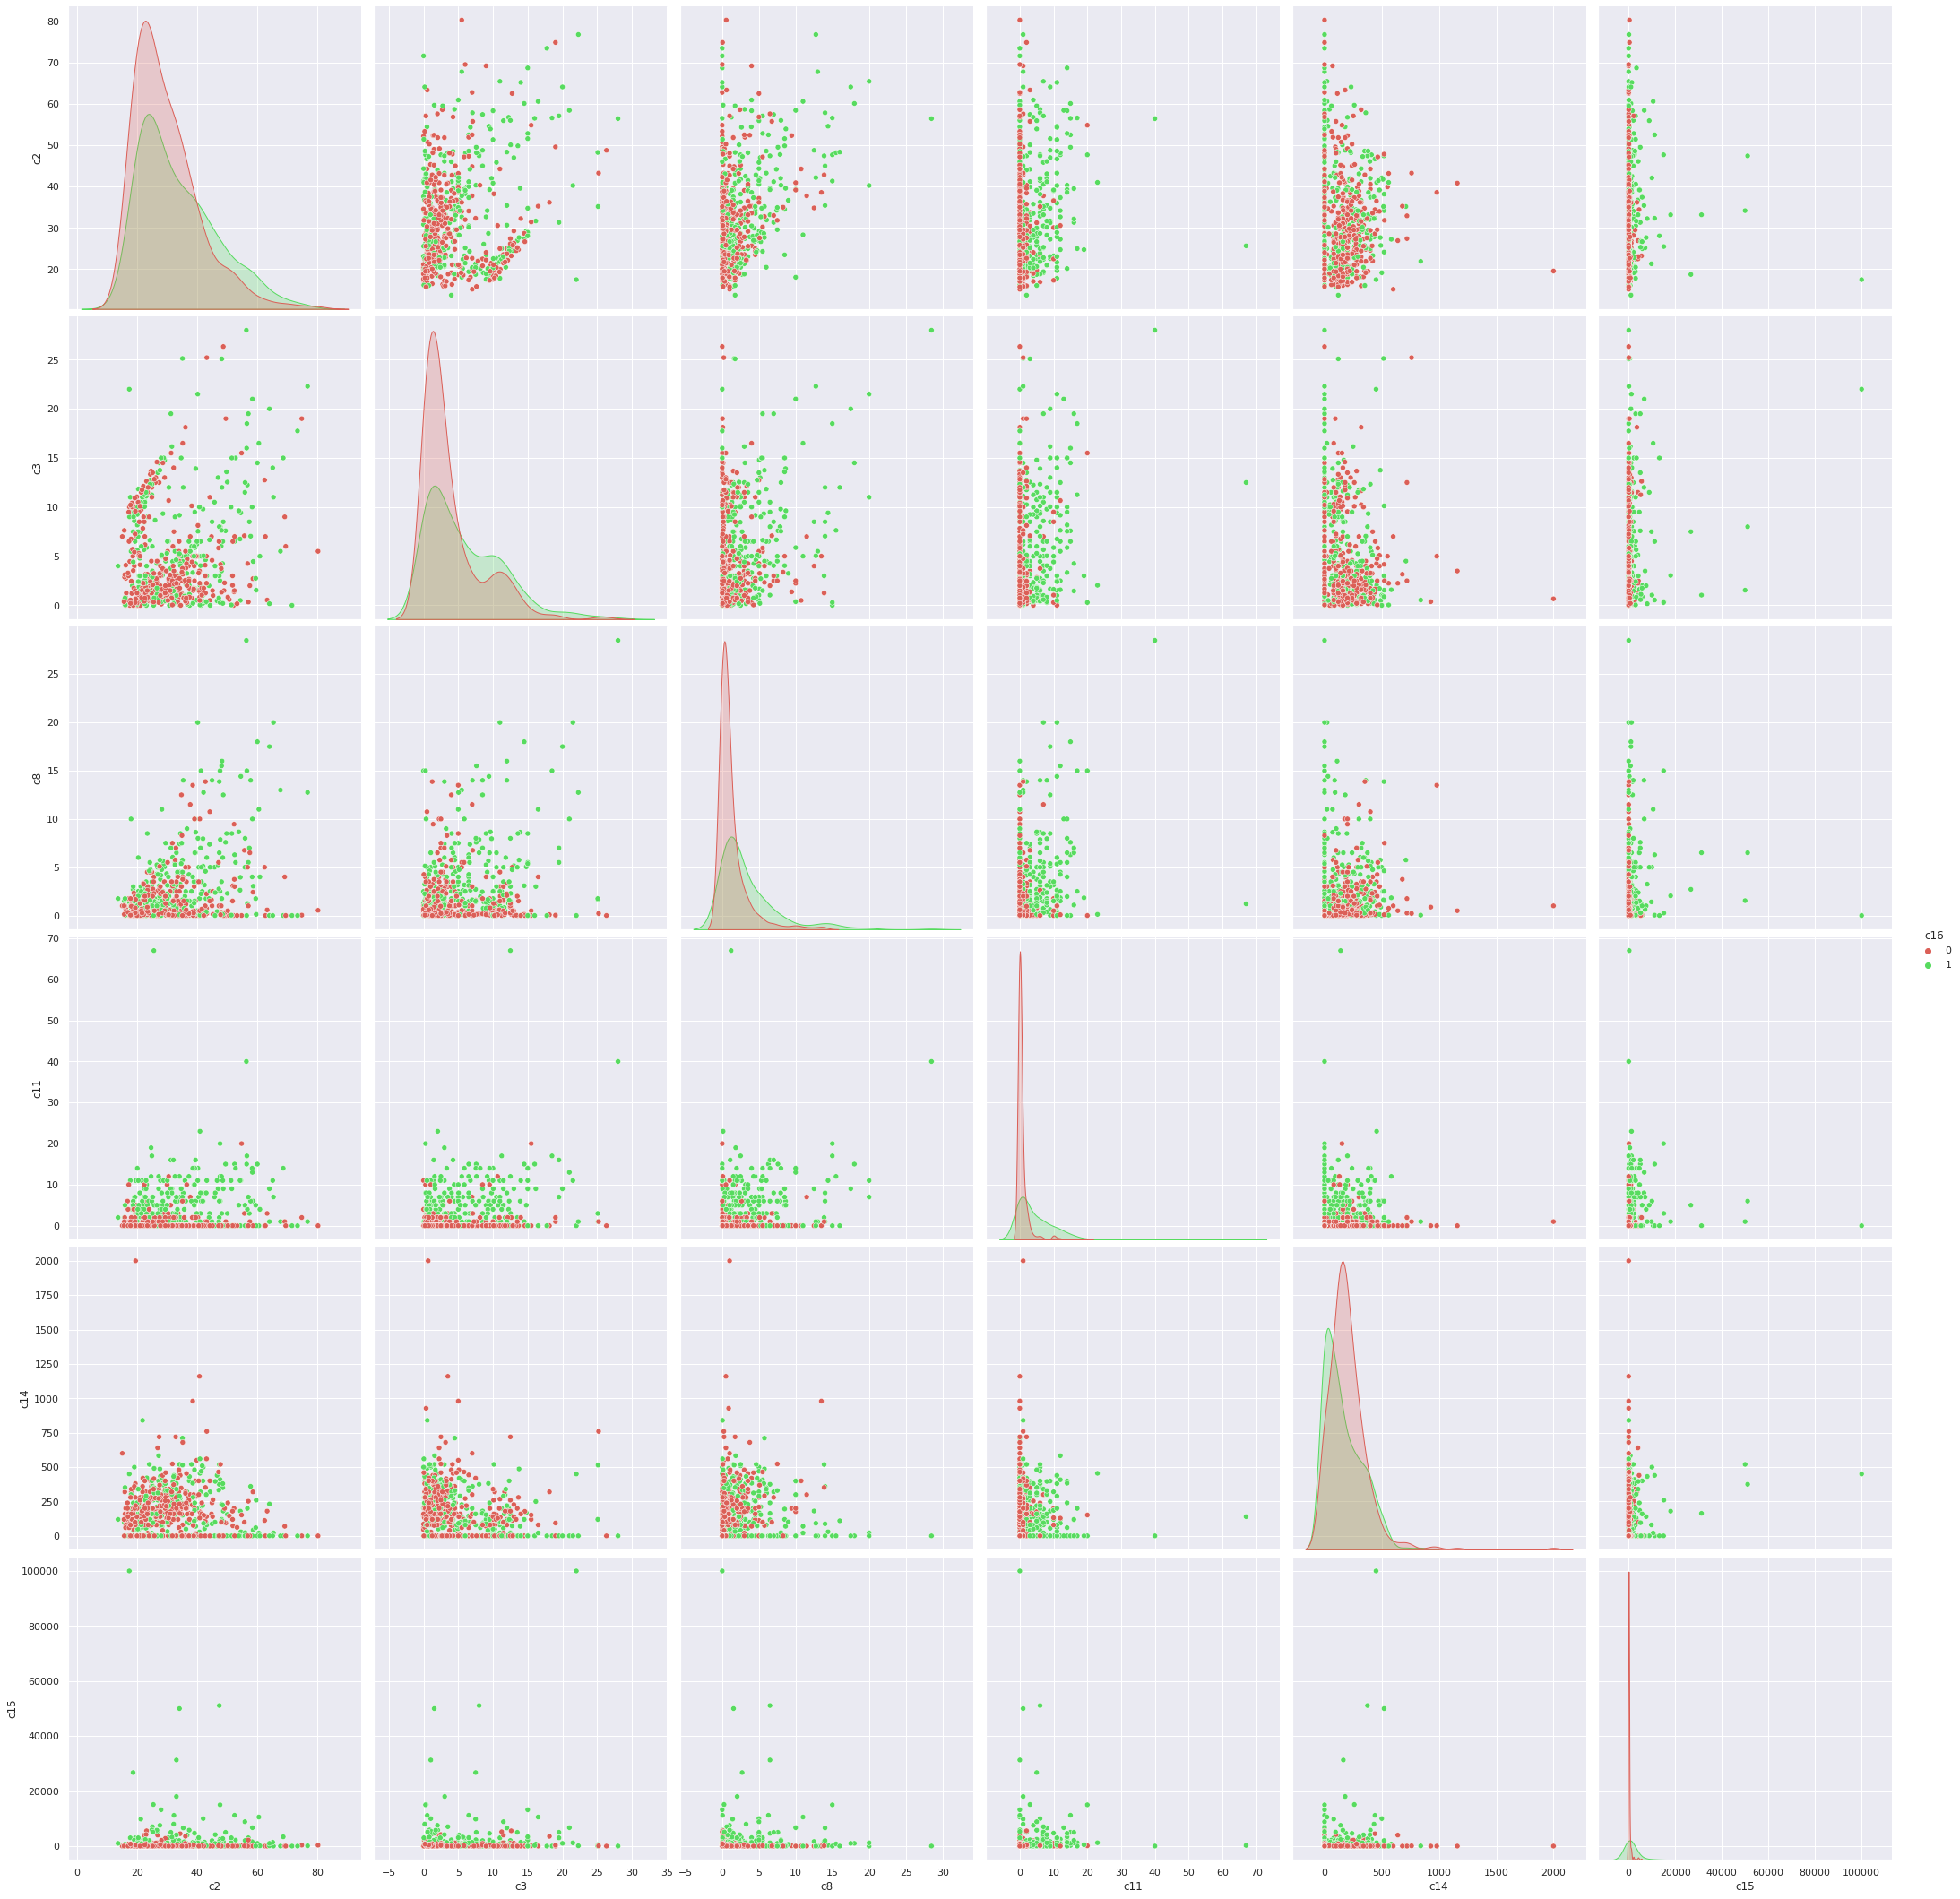

In [34]:
g = sns.pairplot(crp_df[['c2','c3', 'c8','c11','c14','c15','c16']], hue ='c16', height=5)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


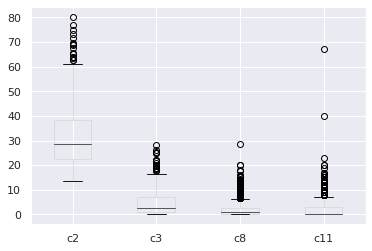

In [35]:
crp_df[['c2','c3', 'c8','c11']].boxplot()

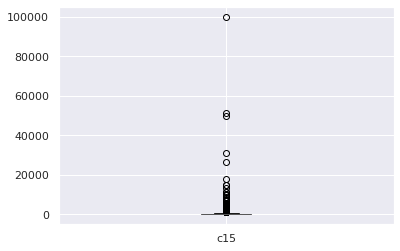

In [36]:
crp_df[['c15']].boxplot()

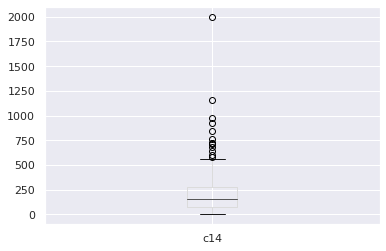

In [37]:
crp_df[['c14']].boxplot()

In [38]:
crp_df[['c2','c3', 'c8','c11','c14','c15','c16']].corr()

,c2,c3,c8,c11,c14,c15,c16
c2,1.000000,0.202317,0.395751,0.185912,-0.079812,0.018553,0.162881
c3,0.202317,1.000000,0.298902,0.271207,-0.224242,0.123121,0.206294
c8,0.395751,0.298902,1.000000,0.322330,-0.077163,0.051345,0.322475
c11,0.185912,0.271207,0.322330,1.000000,-0.120096,0.063692,0.406410
c14,-0.079812,-0.224242,-0.077163,-0.120096,1.000000,0.066853,-0.100935
c15,0.018553,0.123121,0.051345,0.063692,0.066853,1.000000,0.175657
c16,0.162881,0.206294,0.322475,0.406410,-0.100935,0.175657,1.000000


In [39]:
print(len(categorical))

9


posx and posy should be finite values
posx and posy should be finite values


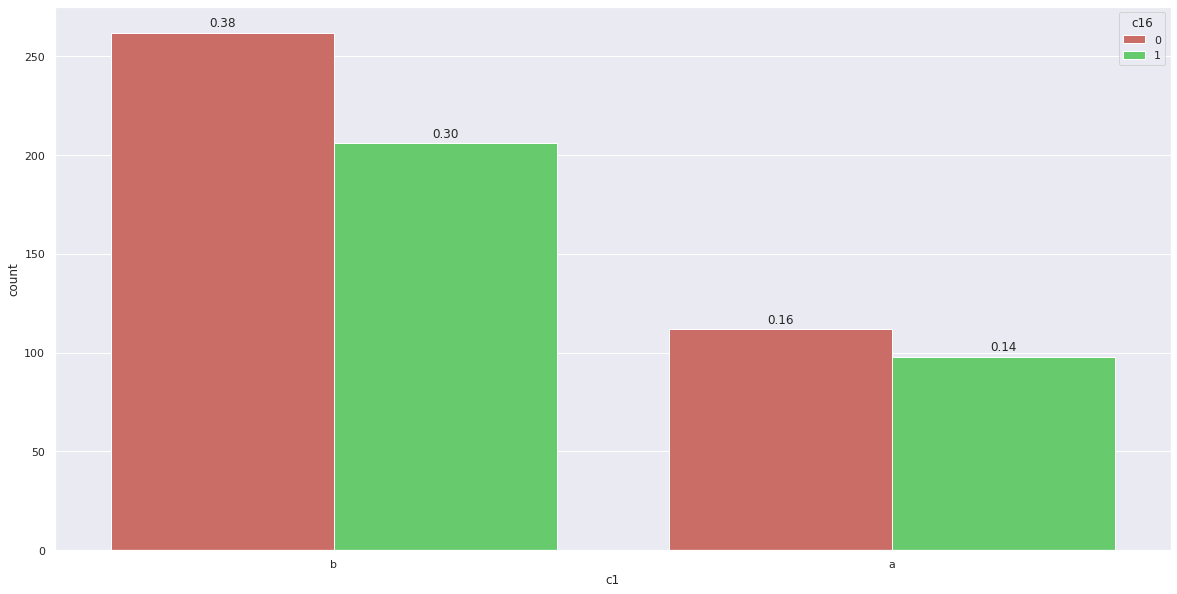

posx and posy should be finite values
posx and posy should be finite values


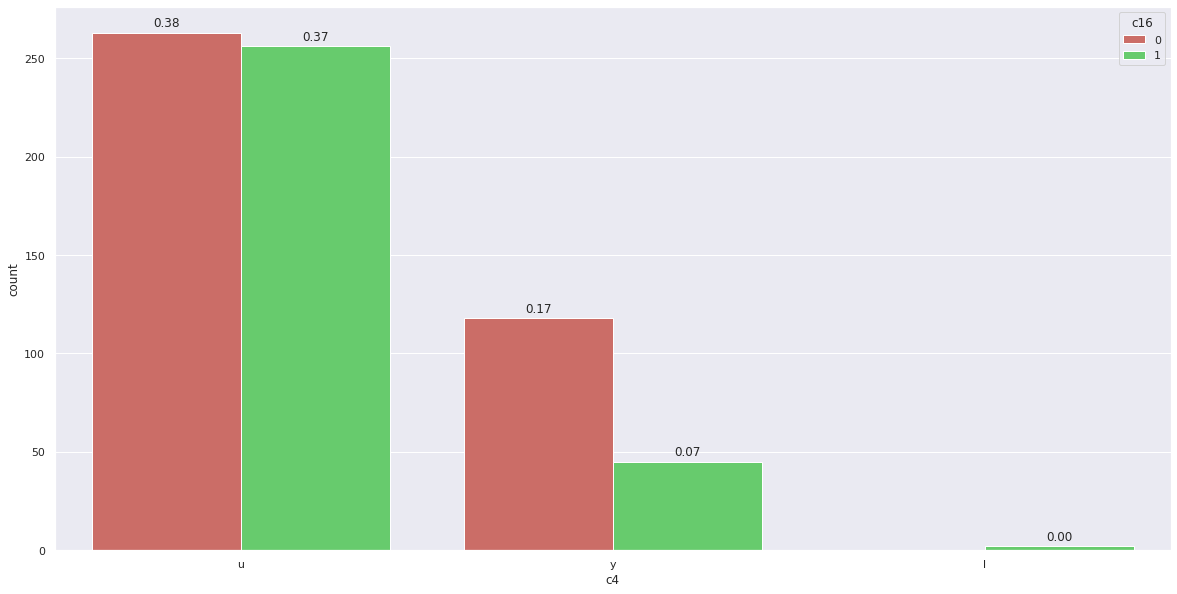

posx and posy should be finite values
posx and posy should be finite values


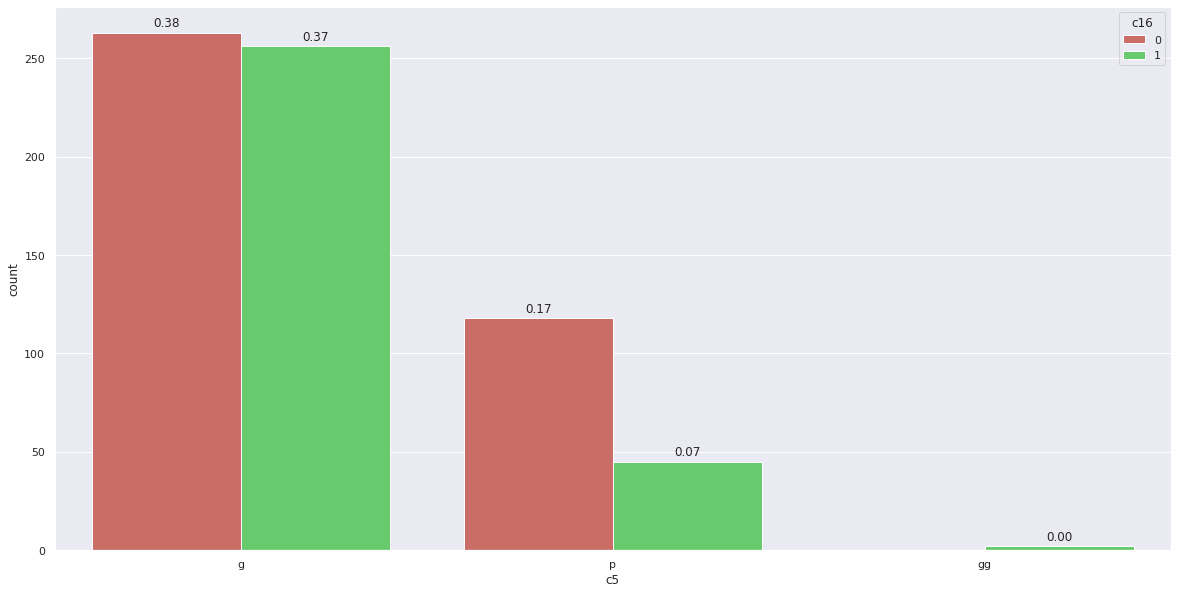

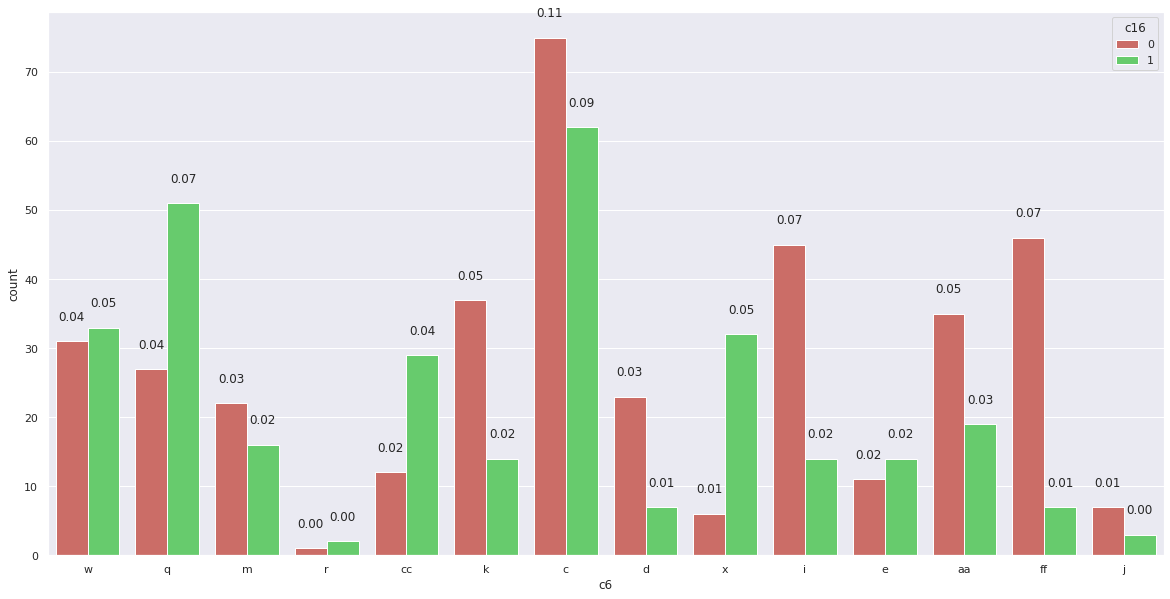

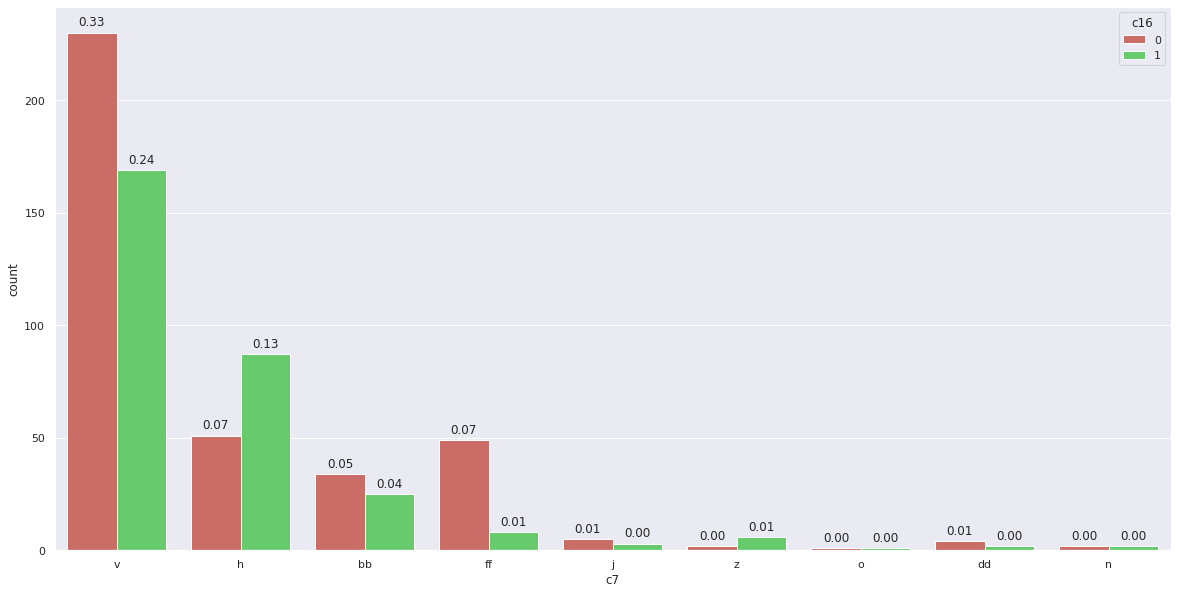

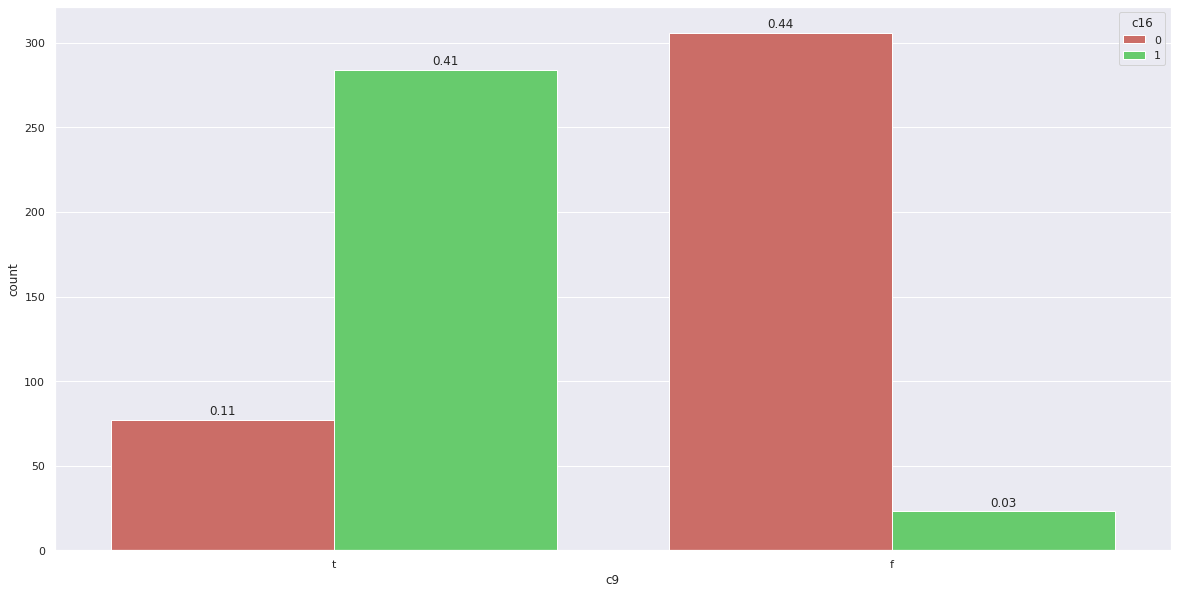

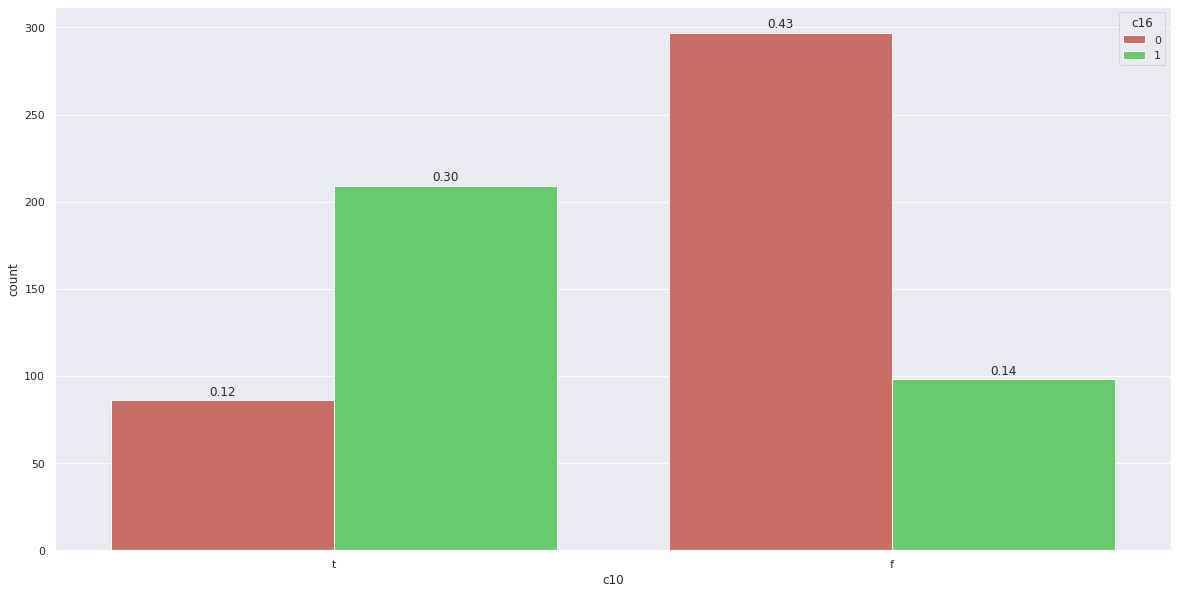

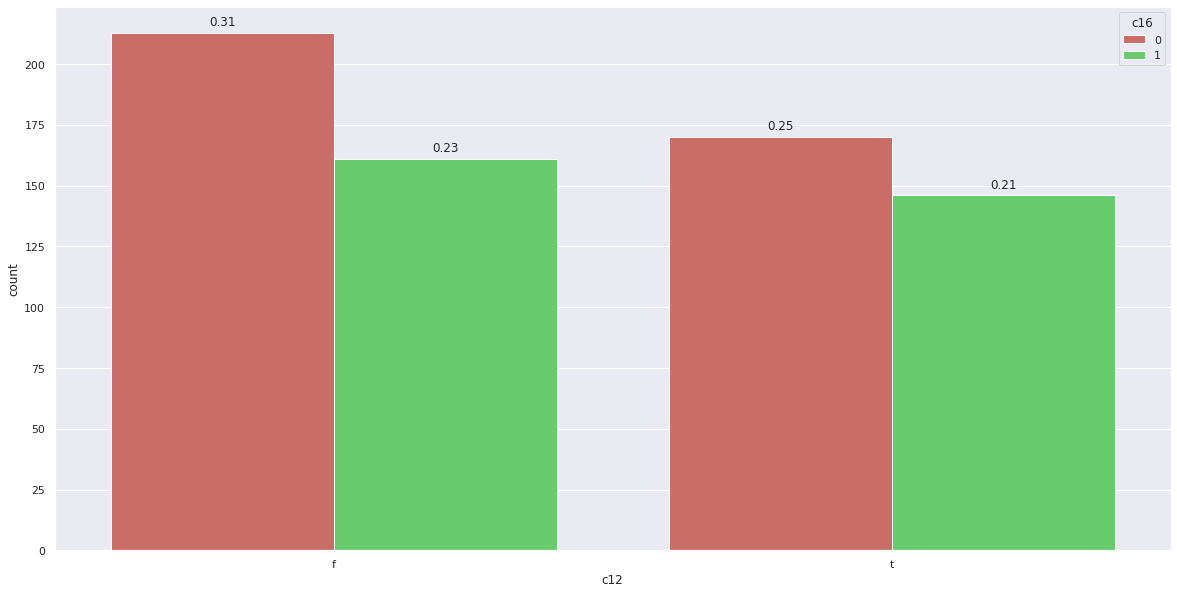

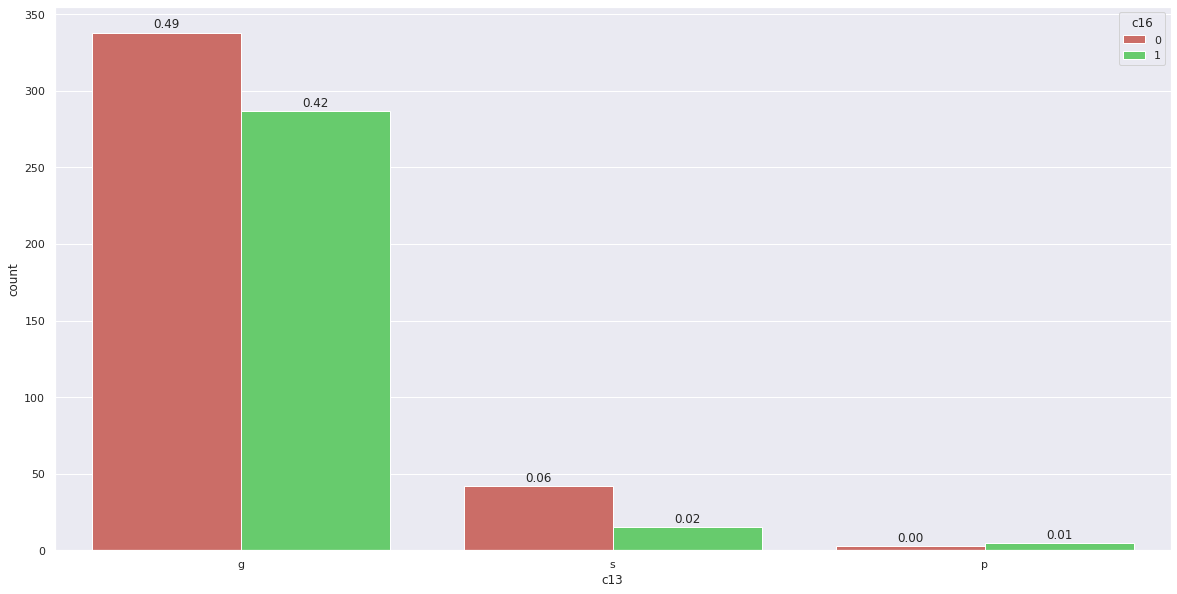

In [40]:
for i in range(len(categorical)) :  
  sns.set(style="darkgrid")
  sns.set_palette("hls", 3)
  plt.figure(figsize=(20,10))
  ax = sns.countplot(x=categorical[i], hue="c16", data=crp_df)

  for p in ax.patches:
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}'.format(height/crp_df.shape[0]),
              ha="center") 

In [41]:
credit_df.count()

690

In [42]:
(train_data, test_data) = credit_df.randomSplit([0.8, 0.2], 24)

print("Records for training: " + str(train_data.count()))
print("Records for evaluation: " + str(test_data.count()))

Records for training: 550
Records for evaluation: 140


In [43]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pysparkling.ml import H2OAutoML
from pysparkling import *
hc = H2OContext.getOrCreate()

Connecting to H2O server at http://da4203769770:54323 ... successful.


H2O_cluster_uptime:,10 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,sparkling-water-root_local-1615866260694
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,858 Mb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.32.0.4-1-2.4
 * H2O name: sparkling-water-root_local-1615866260694
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.28.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://da4203769770:54323 (CMD + click in Mac OSX)

    


In [44]:
train_data.persist()
test_data.cache()

DataFrame[c1: string, c2: double, c3: double, c4: string, c5: string, c6: string, c7: string, c8: double, c9: string, c10: string, c11: int, c12: string, c13: string, c14: int, c15: int, c16: int]

In [45]:
automlEstimator = H2OAutoML(maxRuntimeSecs=60, splitRatio=0.9, labelCol="c16", includeAlgos=['GLM', 'DRF', 'GBM','xgboost'])

In [46]:
h2Omodel = automlEstimator.fit(train_data)

In [47]:
automlEstimator.getLeaderboard().show()

+---+--------------------+----------------------+-------------------+-------------------+-------------------+-------------------+
|   |            model_id|mean_residual_deviance|               rmse|                mse|                mae|              rmsle|
+---+--------------------+----------------------+-------------------+-------------------+-------------------+-------------------+
|  0|XGBoost_grid__1_A...|   0.10162966249036366| 0.3187940753689812|0.10162966249036366|0.20588862004906242|0.22504122568246085|
|  1|GBM_grid__1_AutoM...|   0.10175273112173122| 0.3189870391124555|0.10175273112173122|0.22859604356372884|0.22297059771794098|
|  2|XGBoost_grid__1_A...|   0.10228391986851289| 0.3198185733638884|0.10228391986851289|0.20531901367987046|0.22624581949571645|
|  3|XGBoost_grid__1_A...|   0.10350069986645537| 0.3217152465557941|0.10350069986645537| 0.2010910868042647|0.22610487299875814|
|  4|XGBoost_grid__1_A...|   0.10375149154303691|0.32210478348363114|0.10375149154303691|0

In [48]:
predicted = h2Omodel.transform(test_data)

In [49]:
predicted.take(10)

[Row(c1=None, c2=20.08, c3=0.125, c4='u', c5='g', c6='q', c7='v', c8=1.0, c9='f', c10='t', c11=1, c12='f', c13='g', c14=240, c15=768, c16=1, detailed_prediction=Row(value=0.0005929470062255859), prediction=0.0005929470062255859),
 Row(c1=None, c2=26.5, c3=2.71, c4='y', c5='p', c6=None, c7=None, c8=0.085, c9='f', c10='f', c11=0, c12='f', c13='s', c14=80, c15=0, c16=0, detailed_prediction=Row(value=0.024764657020568848), prediction=0.024764657020568848),
 Row(c1='a', c2=None, c3=3.5, c4='u', c5='g', c6='d', c7='v', c8=3.0, c9='t', c10='f', c11=0, c12='t', c13='g', c14=300, c15=0, c16=0, detailed_prediction=Row(value=0.28428348898887634), prediction=0.28428348898887634),
 Row(c1='a', c2=None, c3=11.25, c4='u', c5='g', c6='ff', c7='ff', c8=0.0, c9='f', c10='f', c11=0, c12='f', c13='g', c14=None, c15=5200, c16=0, detailed_prediction=Row(value=0.07144826650619507), prediction=0.07144826650619507),
 Row(c1='a', c2=16.0, c3=0.165, c4='u', c5='g', c6='aa', c7='v', c8=1.0, c9='f', c10='t', c11=2

In [50]:
h2Omodel.save('h2ospark.model')

In [51]:
stages= []

In [52]:
for catCol in categorical:

    stringIndexer = StringIndexer(inputCol=catCol, outputCol=catCol + "Index", handleInvalid="skip")

    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[catCol + "catVec"])

    stages += [stringIndexer, encoder]

In [53]:
label_Idx = StringIndexer(inputCol="c16", outputCol="label")
stages += [label_Idx]

In [54]:
stages

[StringIndexer_79c8c6e4ed14,
 OneHotEncoderEstimator_97b5e10e6dfd,
 StringIndexer_c0769f08c094,
 OneHotEncoderEstimator_dd9104225752,
 StringIndexer_54248ae64755,
 OneHotEncoderEstimator_a2d782d65fcc,
 StringIndexer_d3f164ae92c4,
 OneHotEncoderEstimator_7d662c063cbb,
 StringIndexer_4e4f949929ad,
 OneHotEncoderEstimator_b748b0fd90b8,
 StringIndexer_8629ef2bf030,
 OneHotEncoderEstimator_b4e644989720,
 StringIndexer_0ee43f1da487,
 OneHotEncoderEstimator_708c9f913708,
 StringIndexer_165dbff4a143,
 OneHotEncoderEstimator_76c8902d6f50,
 StringIndexer_dccfa750d454,
 OneHotEncoderEstimator_5148143c77fa,
 StringIndexer_530a5dd9f32e]

In [55]:
numericCols = ["c2", "c3","c8","c11","c14","c15"]
assembleInputs = assemblerInputs = [c + "catVec" for c in categorical] + numericCols
assembler = VectorAssembler(inputCols=assembleInputs, outputCol="features", handleInvalid="skip")
stages += [assembler]

In [56]:
automlEstimator = H2OAutoML(maxRuntimeSecs=60, splitRatio=0.9, labelCol="c16",includeAlgos=['GBM','xgboost'])
stages += [automlEstimator]

In [57]:
pipeline = Pipeline().setStages(stages)

In [58]:
pipeline.getStages()

[StringIndexer_79c8c6e4ed14,
 OneHotEncoderEstimator_97b5e10e6dfd,
 StringIndexer_c0769f08c094,
 OneHotEncoderEstimator_dd9104225752,
 StringIndexer_54248ae64755,
 OneHotEncoderEstimator_a2d782d65fcc,
 StringIndexer_d3f164ae92c4,
 OneHotEncoderEstimator_7d662c063cbb,
 StringIndexer_4e4f949929ad,
 OneHotEncoderEstimator_b748b0fd90b8,
 StringIndexer_8629ef2bf030,
 OneHotEncoderEstimator_b4e644989720,
 StringIndexer_0ee43f1da487,
 OneHotEncoderEstimator_708c9f913708,
 StringIndexer_165dbff4a143,
 OneHotEncoderEstimator_76c8902d6f50,
 StringIndexer_dccfa750d454,
 OneHotEncoderEstimator_5148143c77fa,
 StringIndexer_530a5dd9f32e,
 VectorAssembler_6dcbc78e914c,
 H2OAutoML_d1a9e35839cf]

In [59]:
pipelinemodel = pipeline.fit(train_data)

In [60]:
pipelinemodel.stages

[StringIndexer_79c8c6e4ed14,
 OneHotEncoderEstimator_97b5e10e6dfd,
 StringIndexer_c0769f08c094,
 OneHotEncoderEstimator_dd9104225752,
 StringIndexer_54248ae64755,
 OneHotEncoderEstimator_a2d782d65fcc,
 StringIndexer_d3f164ae92c4,
 OneHotEncoderEstimator_7d662c063cbb,
 StringIndexer_4e4f949929ad,
 OneHotEncoderEstimator_b748b0fd90b8,
 StringIndexer_8629ef2bf030,
 OneHotEncoderEstimator_b4e644989720,
 StringIndexer_0ee43f1da487,
 OneHotEncoderEstimator_708c9f913708,
 StringIndexer_165dbff4a143,
 OneHotEncoderEstimator_76c8902d6f50,
 StringIndexer_dccfa750d454,
 OneHotEncoderEstimator_5148143c77fa,
 StringIndexer_530a5dd9f32e,
 VectorAssembler_6dcbc78e914c,
 XGBoost_grid__1_AutoML_20210316_034618_model_1_01e4b8218eb5]

In [68]:
last_stage=pipelinemodel.stages[-1]
last_stage.write().save('GBM_H2O.model')

In [69]:
!ls -alrt

total 227904
drwxr-xr-x 13 1000 1000      4096 Sep  8  2020 spark-2.4.7-bin-hadoop2.7
-rw-r--r--  1 root root 233333392 Sep  8  2020 spark-2.4.7-bin-hadoop2.7.tgz
drwxr-xr-x  4 root root      4096 Mar  5 14:36 .config
drwxr-xr-x  1 root root      4096 Mar  5 14:37 sample_data
drwxr-xr-x  1 root root      4096 Mar 16 03:38 ..
drwxr-xr-x  3 root root      4096 Mar 16 03:45 h2ologs
drwxr-xr-x  3 root root      4096 Mar 16 03:46 h2ospark.model
drwxr-xr-x  3 root root      4096 Mar 16 03:47 GBM_H2O.model
drwxr-xr-x  1 root root      4096 Mar 16 03:48 .
drwxr-xr-x  3 root root      4096 Mar 16 03:48 GBM_H2O.zip


In [63]:
prediction = pipelinemodel.transform(test_data)

In [64]:
prediction.take(15)

[Row(c1='a', c2=16.0, c3=0.165, c4='u', c5='g', c6='aa', c7='v', c8=1.0, c9='f', c10='t', c11=2, c12='t', c13='g', c14=320, c15=1, c16=0, c1Index=1.0, c1catVec=SparseVector(1, {}), c4Index=0.0, c4catVec=SparseVector(2, {0: 1.0}), c5Index=0.0, c5catVec=SparseVector(2, {0: 1.0}), c6Index=5.0, c6catVec=SparseVector(13, {5: 1.0}), c7Index=0.0, c7catVec=SparseVector(8, {0: 1.0}), c9Index=1.0, c9catVec=SparseVector(1, {}), c10Index=1.0, c10catVec=SparseVector(1, {}), c12Index=1.0, c12catVec=SparseVector(1, {}), c13Index=0.0, c13catVec=SparseVector(2, {0: 1.0}), label=0.0, features=SparseVector(37, {1: 1.0, 3: 1.0, 10: 1.0, 18: 1.0, 29: 1.0, 31: 16.0, 32: 0.165, 33: 1.0, 34: 2.0, 35: 320.0, 36: 1.0}), detailed_prediction=Row(value=-2.6702880859375e-05), prediction=-2.6702880859375e-05),
 Row(c1='a', c2=17.83, c3=11.0, c4='u', c5='g', c6='x', c7='h', c8=1.0, c9='t', c10='t', c11=11, c12='f', c13='g', c14=0, c15=3000, c16=1, c1Index=1.0, c1catVec=SparseVector(1, {}), c4Index=0.0, c4catVec=Spars

In [65]:
!nvidia-smi

Tue Mar 16 03:47:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    35W / 250W |    291MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [66]:
model1=h2Omodel.load('GBM_H2O.model')

In [67]:
model1.transform(test_data).show()

+----+-----+------+---+---+----+----+-----+---+---+---+---+---+----+----+---+--------------------+--------------------+
|  c1|   c2|    c3| c4| c5|  c6|  c7|   c8| c9|c10|c11|c12|c13| c14| c15|c16| detailed_prediction|          prediction|
+----+-----+------+---+---+----+----+-----+---+---+---+---+---+----+----+---+--------------------+--------------------+
|null|20.08| 0.125|  u|  g|   q|   v|  1.0|  f|  t|  1|  f|  g| 240| 768|  1|[2.82794237136840...|2.827942371368408E-4|
|null| 26.5|  2.71|  y|  p|null|null|0.085|  f|  f|  0|  f|  s|  80|   0|  0|[2.82794237136840...|2.827942371368408E-4|
|   a| null|   3.5|  u|  g|   d|   v|  3.0|  t|  f|  0|  t|  g| 300|   0|  0|[1.80304050445556...|1.803040504455566...|
|   a| null| 11.25|  u|  g|  ff|  ff|  0.0|  f|  f|  0|  f|  g|null|5200|  0|[2.82794237136840...|2.827942371368408E-4|
|   a| 16.0| 0.165|  u|  g|  aa|   v|  1.0|  f|  t|  2|  t|  g| 320|   1|  0|[2.82794237136840...|2.827942371368408E-4|
|   a|17.83|  11.0|  u|  g|   x|   h|  1